# Miniproyecto #3

Modelos y Simulación - Sección 10

Fecha: 28-09-2020

## Integrantes:
* Oscar Juárez - 17315
* José Cifuentes - 17509

## Importación de librerías


In [1]:
import random
import math
from pprint import pprint
import matplotlib.pyplot as plt

## Funciones útiles

In [2]:
def GenerarNuevoTiempo(instante, LambdaPoisson):
    return instante + exponencial(LambdaPoisson)

def exponencial(Lambda):
    U = random.random()
    return -(1/Lambda)*math.log(U)

def TiempoEntreArreglos(llegadas, salidas):
    suma = 0
    for i in range(len(llegadas)):
        suma += salidas[i]-llegadas[i]
    return suma

def TiempoServidorIdle(llegadas, salidas):
    suma = 0
    for i in range(len(llegadas)-1):
        suma += llegadas[i+1]-salidas[i]
    return suma + (0-llegadas[0])

def ServersAreIdle(SS):
    return True if sum(SS[1:]) == 0 else False

def GetNextIdle(SS):
    SS = SS[1:]
    try:
        return SS.index(0)+1
    except:
        return -1

def GetMinT(serverList):
    reqs = [i['t'] for i in serverList]
    minT = min(reqs)
    return minT, reqs.index(minT)


## Algoritmo para servidores dinámicos

In [3]:
def simularServerParalelo(cantServers,LambdaExponencial,LambdaPoisson,T):
  # ------------ Inicializacion ------------
  #Lambda = num. eventos/ num. unidades

  servers = [{
      'llegadas': {},
      'salidas': {},
      't': math.inf
  } for i in range(cantServers)]

  #LambdaPoisson = 2400 / 60
  #LambdaExponencial = 100
  t, Na,Nd = 0,0,0
  SS = [0 for i in range(cantServers + 1)]
  tA = GenerarNuevoTiempo(0, LambdaPoisson)
  #T = 0.1

  cola = {}

  while True:
      # CASO 1

      # Obtenemos el t más pequeño de entre todos los serivdores
      minT, indexMinT = GetMinT(servers)

      # nuevo ingreso en tiempo tA
      if (tA == min(tA, minT) and tA < T):
          # print('CASO1')
          t = tA
          Na += 1
          tA = GenerarNuevoTiempo(t, LambdaPoisson)
          # Obtenemos el próximo servidor que está idle (0)
          idleServer = GetNextIdle(SS)

          if (SS[0] == 0 and ServersAreIdle(SS)):

              SS[1] = Na
              SS[0] = 1

              # todo libre
              servers[0]['llegadas'][Na] = t
              servers[0]['t'] = t + exponencial(LambdaExponencial)

          elif (SS[0] > 0 and idleServer != -1):
              # un cliente y servidor 2 libre
              SS[idleServer] = Na
              SS[0] = SS[0]+1

              # En el servidor correspondiente, marcamos el instante de llegada y el t
              servers[idleServer-1]['llegadas'][Na] = t
              servers[idleServer-1]['t'] = t + exponencial(LambdaExponencial)

          elif SS[0] > len(servers)-1:
              cola[Na] = [t, None]
              SS[0] = SS[0] + 1

          continue

      elif minT < tA:
          t = servers[indexMinT]['t']

          # Obtenemos el id de la solicitud terminada
          # Se suma 1 a indexMintT porque estamos en SS (en donde la primera posición es
          # la cantidad de solicitudes en el sistema)
          solicitudActual = SS[indexMinT + 1]

          # Actualizamos la salida de la solicitud correspondiente
          servers[indexMinT]['salidas'][solicitudActual] = t

          if 0 < SS[0] <= cantServers:
              SS[0] = SS[0]-1
              SS[indexMinT+1] = 0
              servers[indexMinT]['t'] = math.inf

          elif SS[0] > cantServers:
              sigSolicitud = max(SS[1:]) + 1

              SS[indexMinT+1] = sigSolicitud
              SS[0] = SS[0] - 1

              cola[sigSolicitud][1] = indexMinT+1
              servers[indexMinT]['llegadas'][sigSolicitud] = t

              servers[indexMinT]['t'] = t + exponencial(LambdaExponencial)

          continue

      elif SS[0] > 0:

        t = servers[indexMinT]['t']
        solicitudActual = SS[indexMinT + 1]

        # Actualizamos la salida de la solicitud correspondiente
        servers[indexMinT]['salidas'][solicitudActual] = t + \
            exponencial(LambdaExponencial)

        if SS[0] > cantServers:
            sigSolicitud = max(SS[1:]) + 1

            SS[indexMinT+1] = sigSolicitud

            cola[sigSolicitud][1] = indexMinT+1
            servers[indexMinT]['llegadas'][sigSolicitud] = t

            servers[indexMinT]['t'] = t + exponencial(LambdaExponencial)

        else:
            servers[indexMinT]['t'] = math.inf

        # Actualizamos cantidad de solicitudes en el sistema
        SS[0] = SS[0] - 1

        continue

      return servers, cola, t
      break


## Task 1

### Gorilla Megacomputing

Se utiliza el mismo algoritmo de server paralelo ya que este contiene implícitamente los algoritmos para servidores individuales y múltiples.

In [4]:
T=3600
LambdaPoisson = 2400/60
registro, cola, ultimoInstante = simularServerParalelo(cantServers=1, LambdaExponencial=100,LambdaPoisson=LambdaPoisson,T=T)

#### Impresión de resutaldos


In [5]:
# Print de resultados finales
print('LOS RESULTADOS FINALES SON:\n')
server = registro[0]
llegadas = server['llegadas']
print(f'LARGO LLEGADAS: {len(llegadas)} \nLARGO DE COLA: {len(cola)}')

LOS RESULTADOS FINALES SON:

LARGO LLEGADAS: 144211 
LARGO DE COLA: 57744


#### Resultados proveedor 1

1. ¿Cuántas solicitudes atendió cada servidor?

In [6]:
# Se imprime el largo del arreglo de solicitudes que atendió el servidor
solTotalesG1 = len(llegadas)
print(f' El Servidor atendio un total de {solTotalesG1} solicitudes')

 El Servidor atendio un total de 144211 solicitudes


2. ¿Cuánto tiempo estuvo el servidor ocupado?

In [7]:
# Obtenemos una sumatoria de las diferencias entre cada instante que el servidor
# atendió y terminó una solicitud.

salidas = server['salidas'] 
llegadasList = []
salidasList = []
for id in registro[0]['llegadas'].keys():
  llegadasList.append(llegadas[id])
  salidasList.append(salidas[id])

tiempoOcupadoG1 = round(TiempoEntreArreglos(llegadasList, salidasList), 3)
print(f'El Servidor estuvo ocupado {tiempoOcupadoG1} segundos')

El Servidor estuvo ocupado 1444.204 segundos


3. ¿Cuánto tiempo estuvo el servidor desocupado (idle)?

In [8]:
tiempoDesocupadoG1 = round(abs(TiempoServidorIdle(llegadasList, salidasList)), 3)
print(f'El Servidor estuvo desocupado {tiempoDesocupadoG1} segundos')

El Servidor estuvo desocupado 2155.582 segundos


4. ¿Cuánto	tiempo	en	total	estuvieron	las	solicitudes en	cola?

In [9]:
if len(cola) > 0:
  llegadasCola = []
  salidasCola = []
  for i in cola.keys():
    llegadasCola.append(cola[i][0])
    idServidor = cola[i][1]
    idProceso = i
    salidasCola.append(llegadas[idProceso])
  tiempoTotalColaG1 = round(TiempoEntreArreglos(llegadasCola, salidasCola), 3)
  print(f'{tiempoTotalColaG1} segundos')
else:
  print('No hay cola')

971.996 segundos


5. En promedio ¿cuánto tiempo estuvo cada solicitud en cola?

In [10]:
idSolicitudes = []
for i in registro:
  idSolicitudes += i['llegadas'].keys()
promedioCola = tiempoTotalColaG1/max(idSolicitudes)
print(f'{promedioCola} segundos')

0.006740096109173364 segundos


6. En promedio, ¿cuántas solicitudes estuvieron en cola cada segundo?

In [11]:
instantesDeIngresoCola = []
for i in cola.values():
  instantesDeIngresoCola.append(i[0])

llegadasPorSegundo = {}

for i in range(int(max(instantesDeIngresoCola))+1):
  llegadasPorSegundo[i]=0

for i in instantesDeIngresoCola:
  llegadasPorSegundo[int(i)]+=1

suma = sum(llegadasPorSegundo.values())
cantTotal = len(llegadasPorSegundo.values())

promSolColaPorSegundoG1 = int(suma/cantTotal)
print(f'En promedio, {promSolColaPorSegundoG1} solicitudes en cola cada segundo')


En promedio, 16 solicitudes en cola cada segundo


7. ¿Cuál es el momento de la salida de la última solicitud?

In [12]:
tiempoCorridaG1 = round(ultimoInstante, 3)
print(tiempoCorridaG1)

3600.011


### Ant Smart Computing

In [13]:
registroServers, registroCola, ultimoInstante=simularServerParalelo(cantServers=10,LambdaExponencial=10,LambdaPoisson=2400 / 60,T=3600)

#### Resultados proveedor 2

1. ¿Cuántas solicitudes atendió cada servidor?

In [14]:
# Se imprime el largo del arreglo de solicitudes que atendió el servidor
totales = []
for i in range(len(registroServers)):
  total=len(registroServers[i]['llegadas'])
  totales.append(total)
  print(f'Servidor {i} atendio un total de {total} solicitudes')

solTotalesA1 = sum(totales)
print(f'\nSe atendieron {solTotalesG1} solicitudes en total\n')

Servidor 0 atendio un total de 28732 solicitudes
Servidor 1 atendio un total de 26667 solicitudes
Servidor 2 atendio un total de 23499 solicitudes
Servidor 3 atendio un total de 20157 solicitudes
Servidor 4 atendio un total de 16094 solicitudes
Servidor 5 atendio un total de 11779 solicitudes
Servidor 6 atendio un total de 7701 solicitudes
Servidor 7 atendio un total de 4731 solicitudes
Servidor 8 atendio un total de 2475 solicitudes
Servidor 9 atendio un total de 1267 solicitudes

Se atendieron 144211 solicitudes en total



2. ¿Cuánto tiempo estuvo cada servidor ocupado?

In [15]:
# Obtenemos una sumatoria de las diferencias entre cada instante que el servidor
# atendió y terminó una solicitud.
tiemposOA1 = []
for i in range(len(registroServers)):
  try:
    llegadasDict=registroServers[i]['llegadas']
    salidasDict=registroServers[i]['salidas']
    llegadasList=[]
    salidasList=[]
    for id in registroServers[i]['llegadas'].keys():
      llegadasList.append(llegadasDict[id])
      salidasList.append(salidasDict[id])
    
    tiempoOcupado = round(TiempoEntreArreglos(llegadasList, salidasList), 3)
    tiemposOA1.append(tiempoOcupado) 
    print(f'Servidor {i} estuvo ocupado {tiempoOcupado} segundos')
  except:
    print(f'Servidor {i} estuvo ocupado 0 segundos')

tiempoOcupadoA1 =  sum(tiemposOA1) / len(tiemposOA1)

Servidor 0 estuvo ocupado 2880.413 segundos
Servidor 1 estuvo ocupado 2656.576 segundos
Servidor 2 estuvo ocupado 2378.709 segundos
Servidor 3 estuvo ocupado 2015.572 segundos
Servidor 4 estuvo ocupado 1596.259 segundos
Servidor 5 estuvo ocupado 1175.782 segundos
Servidor 6 estuvo ocupado 781.11 segundos
Servidor 7 estuvo ocupado 463.348 segundos
Servidor 8 estuvo ocupado 249.856 segundos
Servidor 9 estuvo ocupado 131.738 segundos


3. ¿Cuánto tiempo estuvo cada servidor desocupado (idle)?

In [16]:
# Hacemos una sumatoria de la diferencia entre instantes cuando el servidor
# terminó una solicitud y entró otra.
tiemposDA1 = []
for i in range(len(registroServers)):
  try:
    llegadasDict=registroServers[i]['llegadas']
    salidasDict=registroServers[i]['salidas']
    llegadasList=[]
    salidasList=[]
    for id in registroServers[i]['llegadas'].keys():
      llegadasList.append(llegadasDict[id])
      salidasList.append(salidasDict[id])
    
    tiempoDesocupado = round(abs(TiempoServidorIdle(llegadasList, salidasList)), 3)
    tiemposDA1.append(tiempoDesocupado)
    print(f'Servidor {i} estuvo desocupado {tiempoDesocupado} segundos')
  except:
    print(f'Servidor {i} estuvo desocupado todo el tiempo')

tiempoDesocupadoA1 = sum(tiemposDA1) / len(tiemposDA1)

Servidor 0 estuvo desocupado 719.6 segundos
Servidor 1 estuvo desocupado 943.478 segundos
Servidor 2 estuvo desocupado 1221.07 segundos
Servidor 3 estuvo desocupado 1584.154 segundos
Servidor 4 estuvo desocupado 2003.348 segundos
Servidor 5 estuvo desocupado 2423.731 segundos
Servidor 6 estuvo desocupado 2818.509 segundos
Servidor 7 estuvo desocupado 3136.032 segundos
Servidor 8 estuvo desocupado 3348.469 segundos
Servidor 9 estuvo desocupado 3466.095 segundos


4. ¿Cuánto	tiempo	en	total	estuvieron	las	solicitudes en	cola?

In [17]:
if (len(registroCola)>0):
  llegadasCola=[]
  salidasCola=[]
  for i in registroCola.keys():
    llegadasCola.append(registroCola[i][0])
    idServidor=registroCola[i][1]
    idProceso=i
    salidasCola.append(registroServers[idServidor-1]['llegadas'][idProceso])
  tiempoTotalColaA1 = round(TiempoEntreArreglos(llegadasCola, salidasCola), 3)
  print(f'{tiempoTotalColaA1} segundos')
else:
  print('No hay cola')


20.227 segundos


5. En promedio ¿cuánto tiempo estuvo cada solicitud en cola?

In [18]:
idSolicitudes=[]
for i in registroServers:
  idSolicitudes+=i['llegadas'].keys()
promedioCola = tiempoTotalColaA1/max(idSolicitudes)
print(f'{promedioCola} segundos')

0.000141346731701863 segundos


6. En promedio, ¿cuántas solicitudes estuvieron en cola cada segundo?

In [19]:
instantesDeIngresoCola=[]
for i in registroCola.values():
  instantesDeIngresoCola.append(i[0])


llegadasPorSegundo={}

for i in range(int(max(instantesDeIngresoCola))+1):
  llegadasPorSegundo[i]=0



for i in instantesDeIngresoCola:
  llegadasPorSegundo[int(i)]+=1


suma=sum(llegadasPorSegundo.values())
cantTotal=len(llegadasPorSegundo.values())

promSolColaPorSegundoA1 = int(suma/cantTotal)
print(f'En promedio, {promSolColaPorSegundoA1} solicitudes en cola cada segundo')


En promedio, 0 solicitudes en cola cada segundo


7. ¿Cuál es el momento de la salida de la última solicitud?

In [20]:
tiempoCorridaA1 = ultimoInstante
print(ultimoInstante)

3600.0779535079214


## Task 2

In [21]:
cantidadServers=10
while True:
  _, registroCola, _=simularServerParalelo(cantServers=cantidadServers,LambdaExponencial=10,LambdaPoisson=2400 / 60,T=3600)
  if (len(registroCola)==0):
    break
  cantidadServers+=1
print(f'{cantidadServers} servidores')

17 servidores


## Task 3

Repetimos el procedimiento anterior, pero con valores distintos y evaluamos las preguntas.

In [22]:
LambdaPoisson = 6000/60
T = 3600

### Gorilla Megacomputing

Nuevamente, realizamos otra simulación con los nuevos valores

In [23]:
registroServers, registroCola, ultimoInstante = simularServerParalelo(
    cantServers=1,
    LambdaExponencial=100,
    LambdaPoisson=LambdaPoisson,
    T=T
  )

#### Análisis de resultados

1. ¿Cuántas solicitudes atendió cada servidor?

In [24]:
# Se imprime el largo del arreglo de solicitudes que atendió el servidor
solTotalesG2 = len(registroServers[0]['llegadas'])
print(f'El Servidor atendio un total de {solTotalesG2} solicitudes')

El Servidor atendio un total de 360614 solicitudes


2. ¿Cuánto tiempo estuvo el servidor ocupado?

In [25]:
# Obtenemos una sumatoria de las diferencias entre cada instante que el servidor
# atendió y terminó una solicitud.

llegadasDict=registroServers[0]['llegadas']
salidasDict=registroServers[0]['salidas']
llegadasList=[]
salidasList=[]
for id in registroServers[0]['llegadas'].keys():
  llegadasList.append(llegadasDict[id])
  salidasList.append(salidasDict[id])
    
tiempoOcupadoG2 = round(TiempoEntreArreglos(llegadasList, salidasList), 3)
print(f'El Servidor estuvo ocupado {tiempoOcupadoG2} segundos')

El Servidor estuvo ocupado 3631.619 segundos


3. ¿Cuánto tiempo estuvo el servidor desocupado (idle)?

In [26]:
# Hacemos una sumatoria de la diferencia entre instantes cuando el servidor
# terminó una solicitud y entró otra.

llegadasDict=registroServers[0]['llegadas']
salidasDict=registroServers[0]['salidas']
llegadasList=[]
salidasList=[]
for id in registroServers[0]['llegadas'].keys():
  llegadasList.append(llegadasDict[id])
  salidasList.append(salidasDict[id])

tiempoDesocupadoG2 = round(abs(TiempoServidorIdle(llegadasList, salidasList)), 3)
print(f'El Servidor estuvo desocupado {tiempoDesocupadoG2} segundos')


El Servidor estuvo desocupado 15.738 segundos


4. ¿Cuánto	tiempo	en	total	estuvieron	las	solicitudes en	cola?

In [27]:
if (len(registroCola)>0):
  llegadasCola=[]
  salidasCola=[]
  for i in registroCola.keys():
    llegadasCola.append(registroCola[i][0])
    idServidor=registroCola[i][1]
    idProceso=i
    salidasCola.append(registroServers[idServidor-1]['llegadas'][idProceso])
  tiempoTotalCola = TiempoEntreArreglos(llegadasCola, salidasCola)
  print(f'{round(tiempoTotalCola, 3)} segundos')
else:
  print('No hay cola')

3624206.521 segundos


5. En promedio ¿cuánto tiempo estuvo cada solicitud en cola?

In [28]:
idSolicitudes=[]
for i in registroServers:
  idSolicitudes+=i['llegadas'].keys()

promedioCola = tiempoTotalCola/max(idSolicitudes)
print(f'{promedioCola} segundos')

10.050099334059231 segundos


6. En promedio, ¿cuántas solicitudes estuvieron en cola cada segundo?

In [29]:
instantesDeIngresoCola=[]
for i in registroCola.values():
  instantesDeIngresoCola.append(i[0])


llegadasPorSegundo={}

for i in range(int(max(instantesDeIngresoCola))+1):
  llegadasPorSegundo[i]=0



for i in instantesDeIngresoCola:
  llegadasPorSegundo[int(i)]+=1


suma=sum(llegadasPorSegundo.values())
cantTotal=len(llegadasPorSegundo.values())

promSolColaPorSegundoG2 = int(suma/cantTotal)
print(f'En promedio, {promSolColaPorSegundoG2} solicitudes en cola cada segundo')


En promedio, 100 solicitudes en cola cada segundo


7. ¿Cuál es el momento de la salida de la última solicitud?

In [30]:
tiempoCorridaG2 = round(ultimoInstante, 3)
print(round(ultimoInstante, 3))

3615.889


### Ant Smart Computing

Nuevamente, realizamos otra simulación con los nuevos valores

In [31]:
registroServers, registroCola, ultimoInstante = simularServerParalelo(
    cantServers=10,
    LambdaExponencial=10,
    LambdaPoisson=LambdaPoisson,
    T=T
  )

#### Análisis de resultados

1. ¿Cuántas solicitudes atendió cada servidor?

In [32]:
# Se imprime el largo del arreglo de solicitudes que atendió el servidor
totales = []
for i in range(len(registroServers)):
  total=len(registroServers[i]['llegadas'])
  totales.append(total)
  print(f'Servidor {i} atendio un total de {total} solicitudes')

solTotalesA2 = sum(totales)
print(f'\nSe atendieron {solTotalesA2} solicitudes en total')

Servidor 0 atendio un total de 36101 solicitudes
Servidor 1 atendio un total de 36133 solicitudes
Servidor 2 atendio un total de 36052 solicitudes
Servidor 3 atendio un total de 36238 solicitudes
Servidor 4 atendio un total de 36217 solicitudes
Servidor 5 atendio un total de 35989 solicitudes
Servidor 6 atendio un total de 36082 solicitudes
Servidor 7 atendio un total de 35940 solicitudes
Servidor 8 atendio un total de 36252 solicitudes
Servidor 9 atendio un total de 35964 solicitudes

Se atendieron 360968 solicitudes en total


2. ¿Cuánto tiempo estuvo el servidor ocupado?

In [33]:
# Obtenemos una sumatoria de las diferencias entre cada instante que el servidor
# atendió y terminó una solicitud.
tiemposOA2 = []
for i in range(len(registroServers)):
  try:
    llegadasDict=registroServers[i]['llegadas']
    salidasDict=registroServers[i]['salidas']
    llegadasList=[]
    salidasList=[]
    for id in registroServers[i]['llegadas'].keys():
      llegadasList.append(llegadasDict[id])
      salidasList.append(salidasDict[id])
    
    tiempoOcupado = round(TiempoEntreArreglos(llegadasList, salidasList),3)
    tiemposOA2.append(tiempoOcupado)
    print(f'Servidor {i} estuvo ocupado {tiempoOcupado} segundos')
  except:
    print(f'Servidor {i} estuvo ocupado 0 segundos')

tiempoOcupadoA2 = sum(tiemposOA2) / len(tiemposOA2)

Servidor 0 estuvo ocupado 3622.444 segundos
Servidor 1 estuvo ocupado 3622.862 segundos
Servidor 2 estuvo ocupado 3623.103 segundos
Servidor 3 estuvo ocupado 3622.332 segundos
Servidor 4 estuvo ocupado 3623.695 segundos
Servidor 5 estuvo ocupado 3623.752 segundos
Servidor 6 estuvo ocupado 3626.961 segundos
Servidor 7 estuvo ocupado 3623.054 segundos
Servidor 8 estuvo ocupado 3624.358 segundos
Servidor 9 estuvo ocupado 3622.554 segundos


3. ¿Cuánto tiempo estuvo el servidor desocupado (idle)?

In [34]:
# Hacemos una sumatoria de la diferencia entre instantes cuando el servidor
# terminó una solicitud y entró otra.
tiemposDA2 = []
for i in range(len(registroServers)):
  try:
    llegadasDict=registroServers[i]['llegadas']
    salidasDict=registroServers[i]['salidas']
    llegadasList=[]
    salidasList=[]
    for id in registroServers[i]['llegadas'].keys():
      llegadasList.append(llegadasDict[id])
      salidasList.append(salidasDict[id])
    
    tiempoOcupado = round(abs(TiempoServidorIdle(llegadasList, salidasList)), 3)
    tiemposDA2.append(tiempoOcupado)
    print(f'Servidor {i} estuvo desocupado {tiempoOcupado} segundos')
  except:
    print(f'Servidor {i} estuvo desocupado todo el tiempo')

tiempoDesocupadoA2 = sum(tiemposDA2) / len(tiemposDA2)

Servidor 0 estuvo desocupado 10.658 segundos
Servidor 1 estuvo desocupado 11.442 segundos
Servidor 2 estuvo desocupado 11.721 segundos
Servidor 3 estuvo desocupado 10.85 segundos
Servidor 4 estuvo desocupado 12.337 segundos
Servidor 5 estuvo desocupado 12.334 segundos
Servidor 6 estuvo desocupado 15.555 segundos
Servidor 7 estuvo desocupado 11.61 segundos
Servidor 8 estuvo desocupado 12.628 segundos
Servidor 9 estuvo desocupado 11.269 segundos


4. ¿Cuánto	tiempo	en	total	estuvieron	las	solicitudes en	cola?

In [35]:
if (len(registroCola)>0):
  llegadasCola=[]
  salidasCola=[]
  for i in registroCola.keys():
    llegadasCola.append(registroCola[i][0])
    idServidor=registroCola[i][1]
    idProceso=i
    salidasCola.append(registroServers[idServidor-1]['llegadas'][idProceso])
  tiempoTotalCola = TiempoEntreArreglos(llegadasCola, salidasCola)
  print(f'{round(tiempoTotalCola, 3)} segundos')
else:
  print('No hay cola')

1912835.509 segundos


5. En promedio ¿cuánto tiempo estuvo cada solicitud en cola?

In [36]:
idSolicitudes=[]
for i in registroServers:
  idSolicitudes+=i['llegadas'].keys()
promedioCola = tiempoTotalCola/max(idSolicitudes)
print(f'{promedioCola} segundos')

5.299183056119898 segundos


6. En promedio, ¿cuántas solicitudes estuvieron en cola cada segundo?

In [37]:
instantesDeIngresoCola=[]
for i in registroCola.values():
  instantesDeIngresoCola.append(i[0])


llegadasPorSegundo={}

for i in range(int(max(instantesDeIngresoCola))+1):
  llegadasPorSegundo[i]=0



for i in instantesDeIngresoCola:
  llegadasPorSegundo[int(i)]+=1


suma=sum(llegadasPorSegundo.values())
cantTotal=len(llegadasPorSegundo.values())
promSolColaPorSegundoA2 = int(suma/cantTotal)
print(f'En promedio, {promSolColaPorSegundoA2} solicitudes en cola cada segundo')


En promedio, 100 solicitudes en cola cada segundo


7. ¿Cuál es el momento de la salida de la última solicitud?

In [38]:
tiempoCorridaA2 = round(ultimoInstante, 3)
print(ultimoInstante)

3611.7785925160993


## Task 4

In [39]:
cantidadServers=10
while True:
  _, registroCola, _=simularServerParalelo(cantServers=cantidadServers,LambdaExponencial=10,LambdaPoisson=6000/60,T=3600)
  if (len(registroCola)==0):
    break
  cantidadServers+=1
print(f'{cantidadServers} Servidores')

28 Servidores


## Task 5

Para conocer el rendimiento de los proveedores, se realizará una serie de gráficos resumiendo algunos datos de las simulaciones.

### **Simulación 1:** 2400 solicitudes por minuto, simulado 1 hora

#### Total de solicitudes procesadas

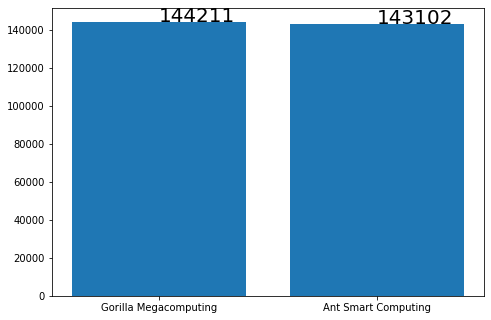

In [40]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
proveedores = ['Gorilla Megacomputing', 'Ant Smart Computing']
totales = [solTotalesG1, solTotalesA1]
ax.bar(proveedores, totales)
for index,data in enumerate(totales):
    plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=20))
plt.show()

#### Tiempos de utilización


##### Gorilla Megacomputing


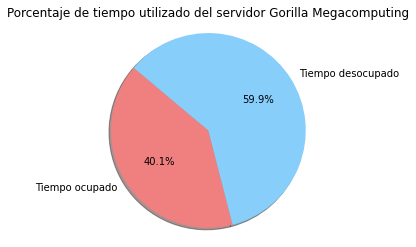

In [41]:
porcentajeOcupado = (tiempoOcupadoG1*100)/tiempoCorridaG1
porcentajeDesocupado = (tiempoDesocupadoG1*100)/tiempoCorridaG1

labels = 'Tiempo ocupado', 'Tiempo desocupado'
sizes = [porcentajeOcupado, porcentajeDesocupado]
colors = ['lightcoral', 'lightskyblue']

plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title('Porcentaje de tiempo utilizado del servidor Gorilla Megacomputing')
plt.show()

##### Ant Smart Computing

Primero, obtendremos el promedio de tiempos por cada servidor de este proveedor.

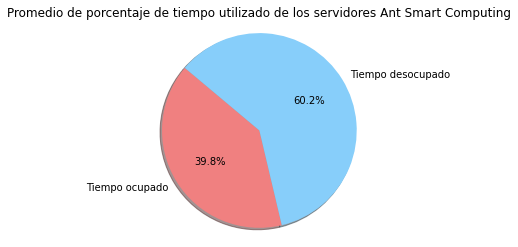

In [42]:
porcentajeOcupado = (tiempoOcupadoA1*100)/tiempoCorridaA1
porcentajeDesocupado = (tiempoDesocupadoA1*100)/tiempoCorridaA1

labels = 'Tiempo ocupado', 'Tiempo desocupado'
sizes = [porcentajeOcupado, porcentajeDesocupado]
colors = ['lightcoral', 'lightskyblue']

plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title('Promedio de porcentaje de tiempo utilizado de los servidores Ant Smart Computing')
plt.show()

Ahora, para un mejor contexto, visualizaremos qué tanto tiempo estuvo ocupado cada servidor individual.

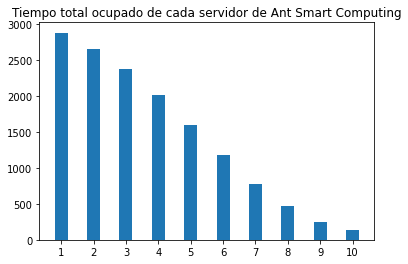

In [43]:
plt.bar(['1','2','3','4','5','6','7','8','9','10'], height=tiemposOA1, width=0.4)
plt.title('Tiempo total ocupado de cada servidor de Ant Smart Computing')
plt.show()

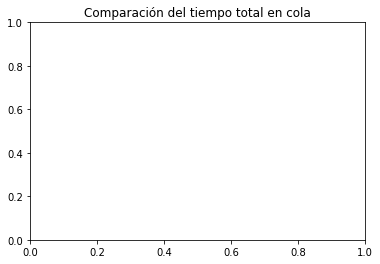

In [44]:
plt.title('Comparación del tiempo total en cola')

porcentajeG1 = (tiempoTotalColaG1*100)/tiempoCorridaG1
porcentajeA1 = (tiempoTotalColaA1*100)/tiempoCorridaA1

#### Promedio de solicitudes en cola por segundo

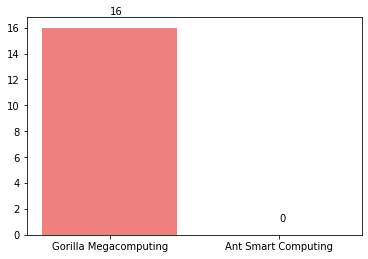

In [45]:
values = [promSolColaPorSegundoG1, promSolColaPorSegundoA1]

for index,data in enumerate(values):
    plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10))

plt.bar(proveedores, height=values, color=colors)
plt.show()

#### Utilización del procesador

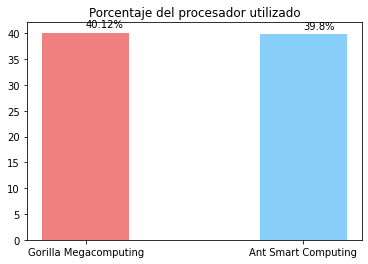

In [46]:
procesadorG1 = round((tiempoOcupadoG1*100)/tiempoCorridaG1, 2)
procesadorA1 = round((tiempoOcupadoA1*100)/tiempoCorridaA1, 2)
values = [procesadorG1, procesadorA1]

for index,data in enumerate(values):
    plt.text(x=index , y =data+1 , s=f"{data}%" , fontdict=dict(fontsize=10))

plt.bar(proveedores, height=values, color=colors, width=0.4)
plt.title('Porcentaje del procesador utilizado')
plt.show()

#### Observaciones simulación 1

Para esta primera simulación, tenemos resultados muy favorables para Ant Smart Computing. A pesar de haber resuelto una cantidad de solicitudes muy parecida, Ant Smart Computing posee un promedio de solicitudes en cola por segundo nulo, es decir, siempre está ocupado procesando y el promedio de solicitudes en cola es 0. Es por ello también que el tiempo promedio ocupado es muy parecido al de Gorilla Megacomputing, sin embargo, este resultado es el *promedio* de lo tiempos de los servidores. Si observamos los resultados de cada servidor individual, nos damos cuenta que hay muchos servidores que están ocupados por muy poco tiempo, indicando así que Ant Smart Computing puede procesar aún más solicitudes en paralelo.


En cuanto a porcentaje del procesador utilizado, ambos parecen tener el mismo rendimiento. No obstante, hay que tener en mente que el tiempo valuado de esta gráfica para Ant Smart Computing es el promedio de todos sus servidores.

### **Simulación 2:** 6000 solicitudes por minuto, simulado 1 hora

#### Total de solicitudes procesadas

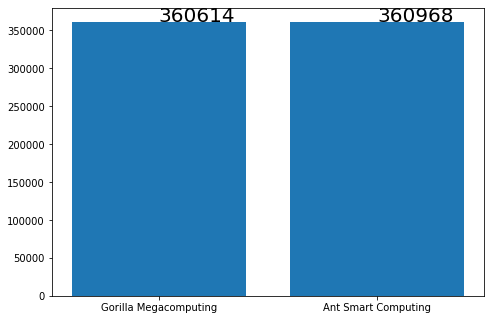

In [47]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
proveedores = ['Gorilla Megacomputing', 'Ant Smart Computing']
totales = [solTotalesG2, solTotalesA2]
ax.bar(proveedores, totales)
for index,data in enumerate(totales):
    plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=20))
plt.show()

#### Tiempos de utilización


##### Gorilla Megacomputing


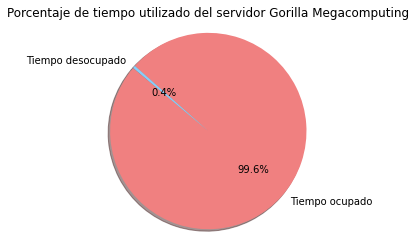

In [48]:
porcentajeOcupado = (tiempoOcupadoG2*100)/tiempoCorridaG2
porcentajeDesocupado = (tiempoDesocupadoG2*100)/tiempoCorridaG2

labels = 'Tiempo ocupado', 'Tiempo desocupado'
sizes = [porcentajeOcupado, porcentajeDesocupado]
colors = ['lightcoral', 'lightskyblue']

plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title('Porcentaje de tiempo utilizado del servidor Gorilla Megacomputing')
plt.show()

##### Ant Smart Computing

Primero, obtendremos el promedio de tiempos por cada servidor de este proveedor.

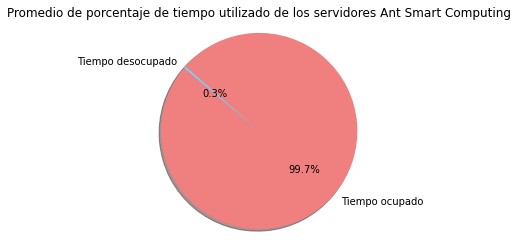

In [49]:
porcentajeOcupado = (tiempoOcupadoA2*100)/tiempoCorridaA2
porcentajeDesocupado = (tiempoDesocupadoA2*100)/tiempoCorridaA2

labels = 'Tiempo ocupado', 'Tiempo desocupado'
sizes = [porcentajeOcupado, porcentajeDesocupado]
colors = ['lightcoral', 'lightskyblue']

plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.title('Promedio de porcentaje de tiempo utilizado de los servidores Ant Smart Computing')
plt.show()

Ahora, para un mejor contexto, visualizaremos qué tanto tiempo estuvo ocupado cada servidor individual.

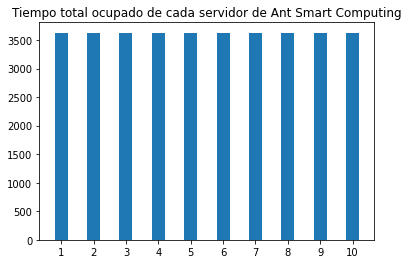

In [50]:
plt.bar(['1','2','3','4','5','6','7','8','9','10'], height=tiemposOA2, width=0.4)
plt.title('Tiempo total ocupado de cada servidor de Ant Smart Computing')
plt.show()

#### Promedio de solicitudes en cola por segundo

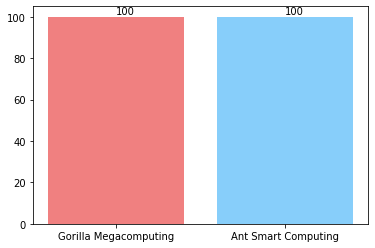

In [51]:
values = [promSolColaPorSegundoG2, promSolColaPorSegundoA2]

for index,data in enumerate(values):
    plt.text(x=index , y =data+1 , s=f"{data}" , fontdict=dict(fontsize=10))

plt.bar(proveedores, height=values, color=colors)
plt.show()

#### Utilización del procesador

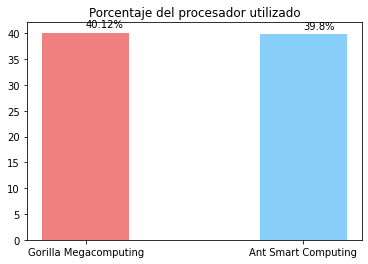

In [52]:
procesadorG2 = round((tiempoOcupadoG2*100)/tiempoCorridaG2, 2)
procesadorA2 = round((tiempoOcupadoA2*100)/tiempoCorridaA2, 2)
values = [procesadorG1, procesadorA1]

for index,data in enumerate(values):
    plt.text(x=index , y =data+1 , s=f"{data}%" , fontdict=dict(fontsize=10))

plt.bar(proveedores, height=values, color=colors, width=0.4)
plt.title('Porcentaje del procesador utilizado')
plt.show()

#### Recomendación a junta directiva:

Podemos notarque el tiempo promedio de solicitudes en cola por segundo es menor para el caso de Ant Smart Computing. Esto significa que las solicitudes esperan menos tiempo usando estos servidores.


En el caso de la segunda simulación podemos observar que ambos servidores tienen un rendimiento muy similar, sin embargo, con los servidores Ant Smart Computing podríamos optar por contratar más servidores individualmente. En pocas palabras, con el paso del tiempo se espera a que la aplicación tenga mayor número de visitas, el servidor de Gorilla Megacomputing se quedaría corto para tantas solicitudes, mientras que Ant Smart Computing si podría seguir aumentando su rendimiento contratando más servidores, por lo que podríamos seguir escalando nuestro negocio al paso que nosotros queramosy por ello nuestra recomendación es que **el mejor proveedor es Ant Smart Computing.**